In [ ]:
# importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Input,Lambda,Subtract,Dropout,BatchNormalization
from keras.layers import ZeroPadding2D,Activation,Layer
from keras.models import Sequential,Model
import keras.backend as K
from keras.utils import plot_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/trainset.zip

Streaming output truncated to the last 5000 lines.
   creating: trainset/0006/0006_0000575/
  inflating: trainset/0006/0006_0000575/0000005.jpg  
  inflating: trainset/0006/0006_0000575/0006_0000575_script.jpg  
   creating: trainset/0006/0006_0000576/
  inflating: trainset/0006/0006_0000576/0000005.jpg  
  inflating: trainset/0006/0006_0000576/0000007.jpg  
  inflating: trainset/0006/0006_0000576/0006_0000576_script.jpg  
  inflating: trainset/0006/0006_0000576/0006_0000576_script_2.jpg  
   creating: trainset/0006/0006_0000577/
  inflating: trainset/0006/0006_0000577/0000001.jpg  
  inflating: trainset/0006/0006_0000577/0000011.jpg  
  inflating: trainset/0006/0006_0000577/0006_0000577_script.jpg  
   creating: trainset/0006/0006_0000580/
  inflating: trainset/0006/0006_0000580/0000004.jpg  
  inflating: trainset/0006/0006_0000580/0006_0000580_script.jpg  
   creating: trainset/0006/0006_0000582/
  inflating: trainset/0006/0006_0000582/0000001.jpg  
  inflating: trainset/0006/0006_00

#Experiment 1: Custom Model
- We will Frame the Problem in to a Supervised 
- Inputs will be two Images and Label will be a binary matching or Not.
- Here we will use simple Convolution Networks for the classification.

### Defining the Generator ,that generates the Inputs and outputs for the Training.

In [ ]:
## Detecting the Faces in the given Images
## Croping the Faces from the Images
classfier=cv2.CascadeClassifier("/content/haarcascade_frontalface_default.xml")
def FaceExtractor(image_path):
    image=cv2.imread(image_path)
    bboxes = classfier.detectMultiScale(image,1.1, 5)
    if(len(bboxes)==1):
        x1,y1,w,h=bboxes[0]
        crop_img=image[y1:y1+h,x1:x1+w]
        crop_img=cv2.resize(crop_img,(128,128))
        crop_img=crop_img/255
        return [1,crop_img]
    else:
        return [0,None]
    

In [ ]:
## Getting Database Images and Reference Images 
## Dataset be : Image_1 , Image_2 , Output
## Here we are dealing with the kind of supervised learning
path="/content/trainset"
def Preparing_dataset(batch_size=32):
    Image_1=[]
    Image_2=[]
    output=[]
    path="./trainset"

    ## Generating the Matching and Not maching Image of batch size of 32 for the every iteration.
    while(True):
        while(True):
            if(len(output)>batch_size-1):
                break

            fold=np.random.choice(os.listdir(path),size=1,replace=False)
            fold_path=os.path.join(path,fold[0])
            match=np.random.choice([0,1],p=[0.5,0.5])

            ## Generating the Random Images which are Matching
            if(match==1):
                sub_fold=np.random.choice(os.listdir(fold_path),size=1,replace=False)

                sub_fold_path=os.path.join(fold_path,sub_fold[0])
                im_1,im_2=tuple(np.random.choice(os.listdir(sub_fold_path),size=2,replace=False))

                ### Extracting the Only Faces from the Images
                f1,crop_1=FaceExtractor(os.path.join(sub_fold_path,im_1))
                f2,crop_2=FaceExtractor(os.path.join(sub_fold_path,im_2))

                if(f1==0 or f2==0):
                    continue
                Image_1.append(crop_1)
                Image_2.append(crop_2)
                output.append(1)


            ### Generating the Random Images which are Not Matching with the each other.
            else:
                sub_fold_1,sub_fold_2=np.random.choice(os.listdir(fold_path),size=2,replace=False)
                sub_fold_1_path=os.path.join(fold_path,sub_fold_1)
                sub_fold_2_path=os.path.join(fold_path,sub_fold_2)

                im_1=np.random.choice(os.listdir(sub_fold_1_path),size=1,replace=False)
                im_2=np.random.choice(os.listdir(sub_fold_2_path),size=1,replace=False)
                f1,crop_1=FaceExtractor(os.path.join(sub_fold_1_path,im_1[0]))
                f2,crop_2=FaceExtractor(os.path.join(sub_fold_2_path,im_2[0]))
                if(f1==0 or f2==0):
                    continue
                Image_1.append(crop_1)
                Image_2.append(crop_2)
                output.append(0)
        yield [np.array(Image_1),np.array(Image_2)],np.array(output)
            

### Building the Siemese Network
- Here we have two sister Networks with the Shared networks.
- The Network is used to get the Embedding Vectors for the Images 

In [ ]:
input_shape=(128,128,3)
Image_1=Input(input_shape)
Image_2=Input(input_shape)
simese=Sequential()
simese.add(Conv2D(32, (5,5),activation='relu',input_shape=input_shape))
simese.add(MaxPooling2D())
simese.add(Dropout(0.5))
simese.add(Flatten())
simese.add(Dense(64,activation="relu"))
simese.add(Dropout(0.5))
simese.add(Dense(100,activation="relu"))
simese.add(Dropout(0.5))
simese.add(Dense(128,activation="relu"))

encode_1=simese(Image_1)
encode_2=simese(Image_2)

sub=Subtract()([encode_1,encode_2])
both = Lambda(lambda x: abs(x))(sub)

prediction = Dense(1,activation='sigmoid')(both)
siamese_net = Model(inputs=[Image_1,Image_2],outputs=prediction)

In [ ]:
siamese_net.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 128)          7894436     input_10[0][0]                   
                                                                 input_11[0][0]                   
__________________________________________________________________________________________________
subtract_1 (Subtract)           (None, 128)          0           sequential_1[0][0]         

In [ ]:
siamese_net.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
val_gen=Preparing_dataset()
history=siamese_net.fit(Preparing_dataset(),steps_per_epoch=10,epochs=15,validation_data=val_gen,validation_steps=2)

Epoch 1/15
10/10 [==============================] - 19s 2s/step - loss: 1.3705 - accuracy: 0.4917 - val_loss: 0.6879 - val_accuracy: 0.5312
Epoch 2/15
10/10 [==============================] - 0s 37ms/step - loss: 0.8156 - accuracy: 0.5115 - val_loss: 0.6924 - val_accuracy: 0.4688
Epoch 3/15
10/10 [==============================] - 0s 33ms/step - loss: 0.6967 - accuracy: 0.4635 - val_loss: 0.6918 - val_accuracy: 0.5625
Epoch 4/15
10/10 [==============================] - 0s 33ms/step - loss: 0.6871 - accuracy: 0.5707 - val_loss: 0.6883 - val_accuracy: 0.5938
Epoch 5/15
10/10 [==============================] - 0s 33ms/step - loss: 0.6765 - accuracy: 0.6284 - val_loss: 0.6868 - val_accuracy: 0.6250
Epoch 6/15
10/10 [==============================] - 0s 33ms/step - loss: 0.6516 - accuracy: 0.6178 - val_loss: 0.6944 - val_accuracy: 0.5000
Epoch 7/15
10/10 [==============================] - 0s 34ms/step - loss: 0.6276 - accuracy: 0.6766 - val_loss: 0.7111 - val_accuracy: 0.6250
Epoch 8/15
10/

Text(0.5, 1.0, 'Accuracy of training and validation plots')

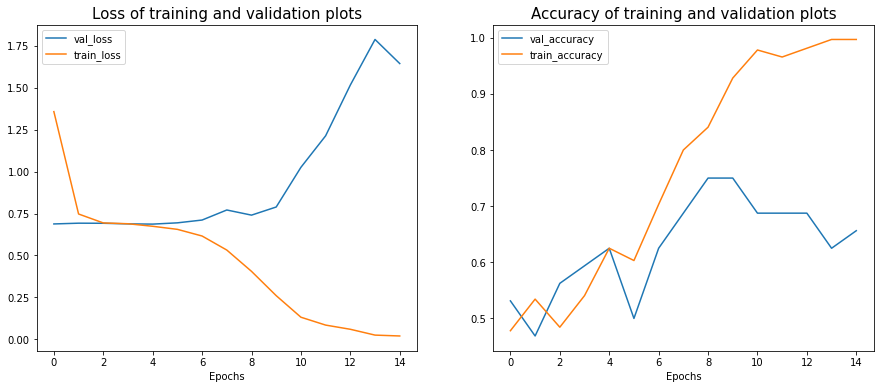

In [ ]:
## plotting theh loss of training and validation
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.plot(history.history["val_loss"],label="val_loss")
plt.plot(history.history["loss"],label="train_loss")
plt.legend()
plt.xlabel("Epochs")
plt.title("Loss of training and validation plots",size=15)

plt.subplot(122)
plt.plot(history.history["val_accuracy"],label="val_accuracy")
plt.plot(history.history["accuracy"],label="train_accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.title("Accuracy of training and validation plots",size=15)

***Model CheckPoint***
- At epoch 8 Model exhibiting the good Accuracy 

### Experiment 2: Building the Simese Network

- Architure of this Network is taking the reference from the simense network of signature

In [ ]:
input_shape=(128,128,3)
Image_1=Input(input_shape)
Image_2=Input(input_shape)


SisterNet=Sequential()
# conv_1
SisterNet.add(Conv2D(64,(10,10),activation="relu",input_shape=input_shape))
SisterNet.add(BatchNormalization())
SisterNet.add(MaxPooling2D())
SisterNet.add(Dropout(0.5))
## conv_2
SisterNet.add(Conv2D(128,(7,7),activation="relu"))
SisterNet.add(BatchNormalization())
SisterNet.add(MaxPooling2D())
SisterNet.add(Dropout(0.3))

## conv_3
SisterNet.add(Conv2D(128,(4,4),activation="relu"))
SisterNet.add(BatchNormalization())
SisterNet.add(MaxPooling2D())
SisterNet.add(Dropout(0.2))

## conv_4
SisterNet.add(Conv2D(256,(4,4),activation="relu"))
SisterNet.add(BatchNormalization())
SisterNet.add(MaxPooling2D())

### Embedding Layer
SisterNet.add(Flatten())
SisterNet.add(Dense(128,activation="relu"))


## Defining The sister Layers
encode_1=SisterNet(Image_1)
encode_2=SisterNet(Image_2)

### Calculating the Distance For this here we using the Lambda Layer
distance=Subtract()([encode_1,encode_2])
distance=Lambda(lambda x:abs(x))(distance)
prediction=Dense(1,activation="sigmoid")(distance)

Model_exper_1=Model(inputs=[Image_1,Image_2],outputs=prediction)


In [ ]:
### Model summary
Model_exper_1.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 128)          1734336     input_12[0][0]                   
                                                                 input_13[0][0]                   
__________________________________________________________________________________________________
subtract_2 (Subtract)           (None, 128)          0           sequential_2[0][0]         

In [ ]:
### Compiling and Fitting the Model
val_gen=Preparing_dataset()
Model_exper_1.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
history=Model_exper_1.fit(Preparing_dataset(),steps_per_epoch=10,epochs=15,validation_data=val_gen,validation_steps=2)

Epoch 1/15
10/10 [==============================] - 34s 4s/step - loss: 1.3558 - accuracy: 0.6335 - val_loss: 0.6657 - val_accuracy: 0.5938
Epoch 2/15
10/10 [==============================] - 1s 112ms/step - loss: 0.0874 - accuracy: 0.9814 - val_loss: 0.7204 - val_accuracy: 0.5938
Epoch 3/15
10/10 [==============================] - 1s 113ms/step - loss: 0.0251 - accuracy: 0.9914 - val_loss: 0.8957 - val_accuracy: 0.5625
Epoch 4/15
10/10 [==============================] - 1s 115ms/step - loss: 0.0107 - accuracy: 1.0000 - val_loss: 1.0744 - val_accuracy: 0.5938
Epoch 5/15
10/10 [==============================] - 1s 111ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.8948 - val_accuracy: 0.6562
Epoch 6/15
10/10 [==============================] - 1s 114ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 1.6212 - val_accuracy: 0.4375
Epoch 7/15
10/10 [==============================] - 1s 114ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 1.4799 - val_accuracy: 0.3125
Epoch 8/

Text(0.5, 1.0, 'Accuracy of training and validation plots')

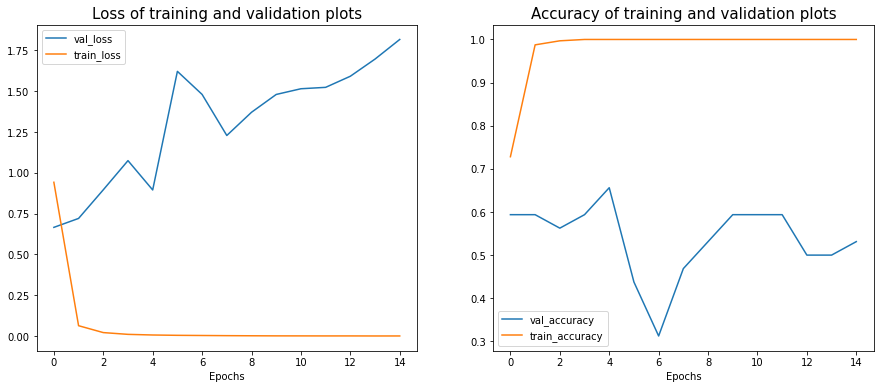

In [ ]:
## plotting theh loss of training and validation
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.plot(history.history["val_loss"],label="val_loss")
plt.plot(history.history["loss"],label="train_loss")
plt.legend()
plt.xlabel("Epochs")
plt.title("Loss of training and validation plots",size=15)

plt.subplot(122)
plt.plot(history.history["val_accuracy"],label="val_accuracy")
plt.plot(history.history["accuracy"],label="train_accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.title("Accuracy of training and validation plots",size=15)

- Model Getting Overfitting Even though we applied Dropout
- This may due to the having the less data for the Complex model

# Experiment 3: Face recognization using Pretrained Models

- Using the arctitecture of VGG16
- using Triplet Loss
- Evelution is based on the Similarity metric (distance)


### Pipeline of FaceNet

- Need to get an triplet dataset(Anchor, Positive, Negitive)
- Preprocess the dataset 
              - Detect faces
              -Transform it
              - Crop 
              - Align (In this i am not going to use the Alignment)
- Representation(To get an to learn an embedding here we using the nn4-small v2 model architecture)
- Evalutiion (Distance Metric)

### Preparing the Dataset(Triplets) 
- Here we are creating the generator which generates the Triplets for the every iteration.
- Triplets be the Anchor, Positive , nagitive images.

In [267]:
classfier=cv2.CascadeClassifier("/content/haarcascade_frontalface_default.xml")
def FaceExtractor_trip(image_path):
    image=cv2.imread(image_path)
    
    gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    bboxes = classfier.detectMultiScale(gray,1.1, 5)
    if(len(bboxes)==1):
        x1,y1,w,h=bboxes[0]
        crop_img=image[y1:y1+h,x1:x1+w]
        crop_img=cv2.resize(crop_img,(96,96))
        crop_img=crop_img.astype('float32')/255
        return [1,crop_img]
    else:
        return [0,None]

In [ ]:
## Generating the Random Triplets
def Triplet_generator(batch_size=32):
  anchor=[]
  positive=[]
  negative=[]
  path="/content/trainset"
  while(True):

    while(True):
      if(len(anchor)>batch_size-1):
        break
      fold_p,fold_n=np.random.choice(os.listdir(path),size=2,replace=False)
      fold_p_path=os.path.join(path,fold_p)
      fold_n_path=os.path.join(path, fold_n)
      sub_fold_p=np.random.choice(os.listdir(fold_p_path),size=1,replace=False)
      sub_fold_n=np.random.choice(os.listdir(fold_n_path),size=1,replace=False)
      sub_fold_p_path=os.path.join(fold_p_path,sub_fold_p[0])
      sub_fold_n_path=os.path.join(fold_n_path,sub_fold_n[0])
      
      ## choosing anchor, positive and negitive
      anch=[x for x in os.listdir(sub_fold_p_path) if "script" in x]
      pos=np.random.choice([x for x in os.listdir(sub_fold_p_path) if "script" not in x],size=1,replace=False)
      neg=np.random.choice(os.listdir(sub_fold_n_path),size=1,replace=False)

      f1,crop_a=FaceExtractor_trip(os.path.join(sub_fold_p_path,anch[0]))
      f2,crop_p=FaceExtractor_trip(os.path.join(sub_fold_p_path,pos[0]))
      f3,crop_n=FaceExtractor_trip(os.path.join(sub_fold_n_path,neg[0]))

      if(f1==0 or f2==0 or f3==0):
        continue
      anchor.append(crop_a)
      positive.append(crop_p)
      negative.append(crop_n)

    yield [np.array(anchor),np.array(positive),np.array(negative)],None




In [ ]:
inputs=Triplet_generator()
count=0
Images=None
for i,j in inputs:
  if(count==0):
    Images=i
    count+=1
  else:
    break

Text(0.5, 1.0, 'Negative')

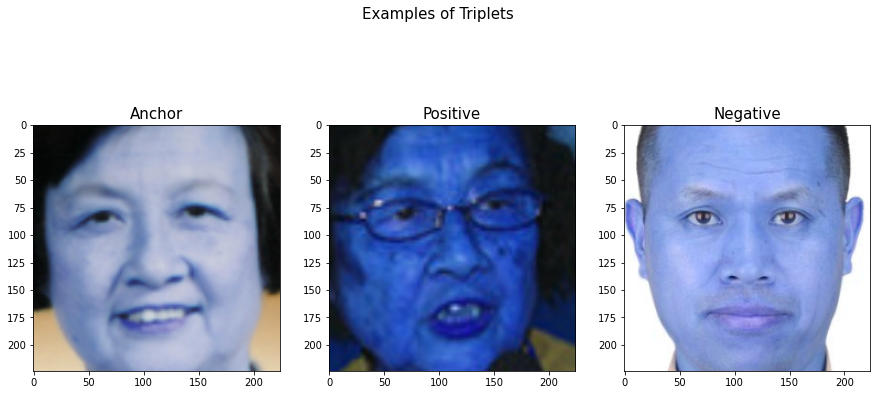

In [ ]:
## plottiong the Images were Anchor, Positive , Negitive Images 
plt.figure(figsize=(15,7))
plt.suptitle("Examples of Triplets",size=15)
plt.subplot(131)
plt.imshow(Images[0][1])
plt.title("Anchor",size=15)
plt.subplot(132)
plt.imshow(Images[1][1])
plt.title("Positive",size=15)
plt.subplot(133)
plt.imshow(Images[2][1])
plt.title("Negative",size=15)


### Building the Simese Network with the Pretrained VGG16

In [ ]:
from keras.applications.vgg16 import VGG16

In [ ]:
model_emb=VGG16(include_top=False,weights="imagenet",input_shape=(96,96,3))
model_emb.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_55 (InputLayer)        [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0     

In [ ]:
for layer in model_emb.layers:
    layer.trainable = False
pool5=model_emb.output


flat = Flatten()(pool5)
fc6 = Dense(2048, activation='relu', name='fc6')(flat)
fc6_drop = Dropout(0.4)(fc6)

embs = Dense(1024, activation='relu', name='fc7')(fc6_drop)
Embedding = Lambda(lambda  x: K.l2_normalize(x, axis=1), name='norm_layer')(embs)

model_vgg=Model(inputs=model_emb.input,outputs=Embedding)
model_vgg.summary()

Model: "model_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_55 (InputLayer)        [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0  

In [ ]:
## Creating the Simese Network
input_shape=(96,96,3)
in_a=Input(input_shape)
in_p=Input(input_shape)
in_n=Input(input_shape)


emb_a=model_vgg(in_a)
emb_p=model_vgg(in_p)
emb_n=model_vgg(in_n)
class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
triplet_loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([emb_a, emb_p, emb_n])

Final_model=Model(inputs=[in_a,in_p,in_n],outputs=triplet_loss_layer)

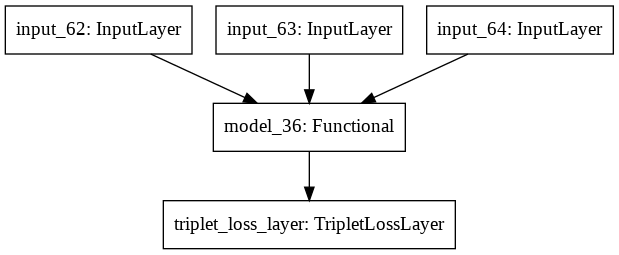

In [ ]:
plot_model(Final_model)

In [ ]:
import tensorflow as tf

In [ ]:
Final_model.compile(loss=None,optimizer=tf.optimizers.Adam(learning_rate=0.00001))
trip_gen=Triplet_generator()
Final_model.fit(Triplet_generator(),epochs=10,steps_per_epoch=200,validation_data=trip_gen,validation_steps=4)

Epoch 1/10
200/200 [==============================] - 47s 229ms/step - loss: 4.1624 - val_loss: 4.6977
Epoch 2/10
200/200 [==============================] - 18s 90ms/step - loss: 2.7067 - val_loss: 4.7509
Epoch 3/10
200/200 [==============================] - 19s 94ms/step - loss: 1.8323 - val_loss: 4.7649
Epoch 4/10
200/200 [==============================] - 18s 89ms/step - loss: 1.2124 - val_loss: 4.7328
Epoch 5/10
200/200 [==============================] - 17s 87ms/step - loss: 0.8258 - val_loss: 4.6751
Epoch 6/10
200/200 [==============================] - 18s 88ms/step - loss: 0.5445 - val_loss: 4.6465
Epoch 7/10
200/200 [==============================] - 18s 89ms/step - loss: 0.3293 - val_loss: 4.6046
Epoch 8/10
200/200 [==============================] - 18s 90ms/step - loss: 0.1994 - val_loss: 4.5790
Epoch 9/10
200/200 [==============================] - 18s 89ms/step - loss: 0.1344 - val_loss: 4.5839
Epoch 10/10
200/200 [==============================] - 18s 88ms/step - loss: 0.10

Text(0.5, 1.0, 'Loss of Training and Validation')

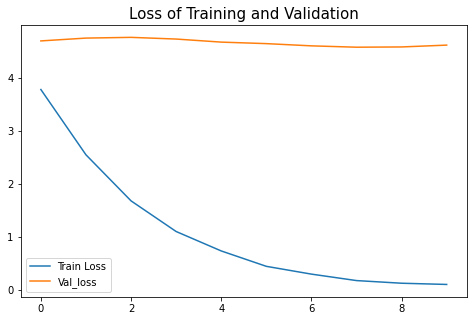

In [ ]:
###Plotting the losses of Training and Validation loasses
hist=Final_model.history.history
plt.figure(figsize=(8,5))
plt.plot(hist["loss"],label="Train Loss")
plt.plot(hist["val_loss"],label="Val_loss")
plt.legend()
plt.title("Loss of Training and Validation",size=15)

#### Pretrained Inception model

In [ ]:
from keras.applications.inception_v3 import InceptionV3

In [ ]:
model_incep=InceptionV3(include_top=False,input_shape=(96,96,3),weights="imagenet")
model_incep.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_48 (InputLayer)           [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 47, 47, 32)   864         input_48[0][0]                   
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 47, 47, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 47, 47, 32)   0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [ ]:
for layer in model_incep.layers:
    layer.trainable = False
Out_put=model_incep.get_layer("mixed4").output


flat = Flatten()(Out_put)
fc6 = Dense(516, activation='relu', name='fc6')(flat)
fc6_drop = Dropout(0.5)(fc6)

embs = Dense(516, activation='relu', name='fc7')(fc6_drop)
Embedding = Lambda(lambda  x: K.l2_normalize(x, axis=1), name='norm_layer')(embs)

In [ ]:
model=Model(inputs=model_incep.input,outputs=Embedding)
model.summary()

Model: "model_32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_48 (InputLayer)           [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 47, 47, 32)   864         input_48[0][0]                   
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 47, 47, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 47, 47, 32)   0           batch_normalization_94[0][0]     
___________________________________________________________________________________________

In [ ]:
## Creating the Simese Network
input_shape=(96,96,3)
in_a=Input(input_shape)
in_p=Input(input_shape)
in_n=Input(input_shape)


emb_a=model(in_a)
emb_p=model(in_p)
emb_n=model(in_n)
class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
triplet_loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([emb_a, emb_p, emb_n])

Final_model_incep=Model(inputs=[in_a,in_p,in_n],outputs=triplet_loss_layer)

In [ ]:
Final_model_incep.compile(loss=None,optimizer=tf.optimizers.Adam(learning_rate=0.000003))
trip_gen=Triplet_generator()
Final_model_incep.fit(Triplet_generator(),epochs=17,steps_per_epoch=200,validation_data=trip_gen,validation_steps=4)

Epoch 1/17
200/200 [==============================] - 39s 177ms/step - loss: 5.7453 - val_loss: 3.1380
Epoch 2/17
200/200 [==============================] - 6s 32ms/step - loss: 4.6049 - val_loss: 2.7980
Epoch 3/17
200/200 [==============================] - 6s 32ms/step - loss: 3.8505 - val_loss: 2.5776
Epoch 4/17
200/200 [==============================] - 6s 32ms/step - loss: 3.1566 - val_loss: 2.4077
Epoch 5/17
200/200 [==============================] - 6s 32ms/step - loss: 2.6379 - val_loss: 2.2957
Epoch 6/17
200/200 [==============================] - 6s 32ms/step - loss: 2.1967 - val_loss: 2.2080
Epoch 7/17
200/200 [==============================] - 6s 32ms/step - loss: 1.8050 - val_loss: 2.1451
Epoch 8/17
200/200 [==============================] - 6s 32ms/step - loss: 1.4578 - val_loss: 2.0933
Epoch 9/17
200/200 [==============================] - 6s 32ms/step - loss: 1.3418 - val_loss: 2.0552
Epoch 10/17
200/200 [==============================] - 6s 32ms/step - loss: 1.0914 - val_

Text(0.5, 1.0, 'Loss of Training and Validation')

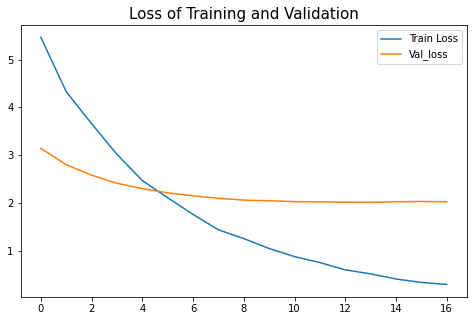

In [ ]:
###Plotting the losses of Training and Validation loasses
hist=Final_model_incep.history.history
plt.figure(figsize=(8,5))
plt.plot(hist["loss"],label="Train Loss")
plt.plot(hist["val_loss"],label="Val_loss")
plt.legend()
plt.title("Loss of Training and Validation",size=15)

In [188]:
### Saving The model
model.save("embedding.h5")

## Testing Images with the Inception Model

In [272]:
### Creating the DataBase fo some images 
Database=[]
path="/content/trainset"
for i in os.listdir(path):
  if(len(Database)>30):
    break
  
  for j in os.listdir(os.path.join(path,i)):
    script_images=[im for im in os.listdir(os.path.join(os.path.join(path,i),j)) if "script" in im]
    img_path=os.path.join(path,i,j,script_images[0])
    f,crop_image=FaceExtractor_trip(img_path)
    if(f==1):
      Database.append(np.array(crop_image))
    if(len(Database)>30):
      break

In [342]:
### LOding the my Image in a Database
f,crop_image=FaceExtractor_trip("//content/testset/sai2.JPG")
if(f==1):
  Database.append(np.array(crop_image))


In [343]:
### Taking two test images
test_1=[]
test_2=[]
f,crop_image=FaceExtractor_trip("/content/testset/sai3.jpg")
if(f==1):
  test_1.append(crop_image)

##test_2
f,crop_image=FaceExtractor_trip("/content/testset/0000010.jpg")
if(f==1):
  test_2.append(crop_image)

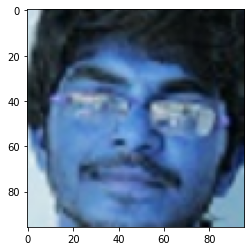

In [344]:
plt.imshow(Database[-1])

In [349]:
### Now Getting the Embedding for the Database Images and Test images 
database_embeds=model.predict(np.array(Database))
emb_test_1=model.predict(np.array(test_1))
emb_test_2=model.predict(np.array(test_2))

In [350]:
def Distance_images(test_emb):
  dist=np.sum(np.abs(database_embeds-test_emb),axis=1)
  return dist

 Image is Mactching with the Image in Database of Index : 32


Text(0.5, 0.98, 'The Distance Between the Target Image and Test Image is :2.6441007')

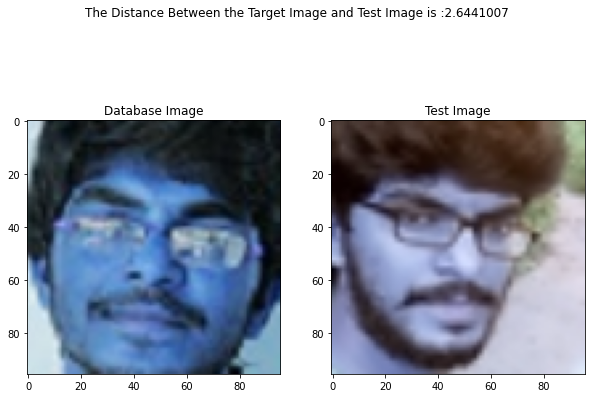

In [363]:
## Predicting the Test 1 example

dist=Distance_images(emb_test_1)
index=np.argmin(dist)
print(" Image is Mactching with the Image in Database of Index :",index)
plt.figure(figsize=(10,7))
plt.subplot(121)
plt.imshow(Database[index])
plt.title("Database Image")

plt.subplot(122)
plt.imshow(test_1[0])
plt.title("Test Image")

plt.suptitle("The Distance Between the Target Image and Test Image is :"+str(dist[index]))

 Image is Mactching with the Image in Database of Index : 21


Text(0.5, 0.98, 'The Distance Between the Target Image and Test Image is :2.3419123')

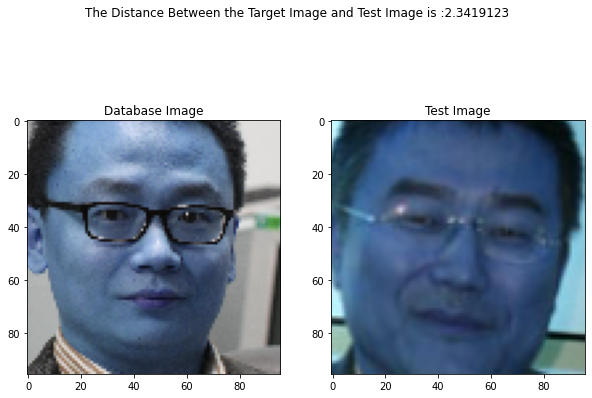

In [364]:
## Predicting the Test 1 example

dist=Distance_images(emb_test_2)
index=np.argmin(dist)
print(" Image is Mactching with the Image in Database of Index :",index)
plt.figure(figsize=(10,7))
plt.subplot(121)
plt.imshow(Database[index])
plt.title("Database Image")

plt.subplot(122)
plt.imshow(test_2[0])
plt.title("Test Image")

plt.suptitle("The Distance Between the Target Image and Test Image is :"+str(dist[index]))

- First images of My self and that was matching the database image and given image.
- Second Example , Got a not correct Prediction.